In [1]:
CSV_FILE = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_12_21_13_01_51/ops_perf_results_2025_12_21_13_01_51.csv"
CSV_FILE2 = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_12_21_12_44_50/ops_perf_results_2025_12_21_12_44_50.csv"
CSV_FILE3 = "/home/ubuntu/tt-metal/generated/profiler/reports/2025_12_21_16_28_22/ops_perf_results_2025_12_21_16_28_22.csv"

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact


In [36]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(CSV_FILE)

# Rename the columns for clarity
df = df.rename(columns={
    'OP CODE': 'Operation',
    'HOST DURATION [ns]': 'Host Time',
    'OP TO OP LATENCY [ns]': 'Time Between Ops',
    'DEVICE FW DURATION [ns]': 'Device Time'
})


# Filter out rows before compilation finished
mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('compilation_finished', na=False)
matching_indices = df.index[mask]
assert not matching_indices.empty, "No 'compilation_finished' found in ProfilerNoopOperation attributes"
latest_compilation_flag = matching_indices[-1]
df = df.iloc[latest_compilation_flag + 1:]

# Find number of training steps
mask = (df['Operation'] == 'ProfilerNoopOperation') & df['ATTRIBUTES'].str.contains('iteration_', na=False)
matching_indices = df.index[mask]
num_training_steps = 3 # for backward compatibility, will be removed before merge
if not matching_indices.empty:
    filtered_df = df[df.index.isin(matching_indices)]
    num_training_steps = len(filtered_df['ATTRIBUTES'].unique())

df = df[df['Operation'] != 'ProfilerNoopOperation']

all_operations = df['Operation'].unique()

num_training_steps

9

In [23]:
df.iloc[100:150].loc[:, ['Operation', 'ATTRIBUTES','Host Time', 'Time Between Ops','Device Time']]

# df.iloc[114]['ATTRIBUTES']


,Operation,ATTRIBUTES,Host Time,Time Between Ops,Device Time
2764,BinaryNgDeviceOperation,{'binary_op_type': 'BinaryOpType::ADD'; 'compu...,11240,161149,298432
2765,RMSNormForwardDeviceOperation,{'epsilon': '1e-05'; 'return_intermediates': '...,6720,613,358417
2766,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},6140,3571,4111
2767,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},2000,2352,4099
2768,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},1590,2352,4093
2769,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},1640,2365,4103
2770,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},1480,2383,4107
2771,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},22810,14652302,4090
2772,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},2930,84978,4114
2773,ProfilerNoopOperation,{'identifier': 'MLP_w1_matmul_start'},1980,43844,4100


In [ ]:
df.iloc[100:150].loc[:, ['Operation', 'Host Time', 'Time Between Ops','Device Time']]


,Operation,Host Time,Time Between Ops,Device Time
1334,Matmul,2620,564,579925
1335,NLPConcatHeadsDeviceOperation,2550,565,815712
1336,Transpose,2710,582,226375
1337,Matmul,2460,640,1129983
1338,BinaryNgDeviceOperation,3750,597,1414485
1339,RMSNormForwardDeviceOperation,3160,550,354323
1340,Transpose,2690,530,378438
1341,Matmul,2670,643,2895389
1342,UnaryDeviceOperation,2950,613,3513599
1343,Transpose,2200,537,193434


In [31]:
df.iloc[100:150].loc[:, ['Operation', 'Host Time', 'Time Between Ops','Device Time']]


,Operation,Host Time,Time Between Ops,Device Time
1334,Matmul,2620,564,579925
1335,NLPConcatHeadsDeviceOperation,2550,565,815712
1336,Transpose,2710,582,226375
1337,Matmul,2460,640,1129983
1338,BinaryNgDeviceOperation,3750,597,1414485
1339,RMSNormForwardDeviceOperation,3160,550,354323
1340,Transpose,2690,530,378438
1341,Matmul,2670,643,2895389
1342,UnaryDeviceOperation,2950,613,3513599
1343,Transpose,2200,537,193434


In [20]:
df.iloc[150:200].loc[:, ['Operation', 'Host Time', 'Time Between Ops','Device Time']]

,Operation,Host Time,Time Between Ops,Device Time
1247,RMSNormForwardDeviceOperation,2900,560,258094
1248,Transpose,2070,526,157571
1249,Matmul,2140,610,932357
1250,Transpose,1920,593,964742
1251,Matmul,1780,642,524329
1252,NlpCreateHeadsDeviceOperation,2460,597,753522
1253,RotaryEmbeddingLlamaDeviceOperation,3110,659,550332
1254,RotaryEmbeddingLlamaDeviceOperation,2350,552,653462
1255,BinaryNgDeviceOperation,2420,558,295332
1256,Untilize,2450,635,56651


In [34]:
def draw_diagrams_with_aggregation(aggregation):
    grouped = df.groupby('Operation').agg({
        'Host Time': aggregation,
        'Time Between Ops': aggregation,
        'Device Time': aggregation
    })

    time_columns = ['Time Between Ops', 'Device Time', 'Host Time']
    topk = 15

    for col in time_columns:
        # ----- top-k + “Others” slice -------------------------------------
        sorted_times = grouped[col].sort_values(ascending=False)
        top_times    = sorted_times.head(topk)
        others_sum   = sorted_times.iloc[topk:].sum()
        if others_sum:
            top_times = pd.concat([top_times, pd.Series({'Others': others_sum})])

        labels = top_times.index.tolist()
        sizes  = top_times.values
        pct    = 100 * sizes / sizes.sum()

        # ----- plot -------------------------------------------------------
        fig, ax = plt.subplots(figsize=(8, 8))
        wedges, _ = ax.pie(sizes, startangle=140)   # no autopct ⇒ nothing on pie

        legend_text = [f'{lbl} — {p:.1f}%' for lbl, p in zip(labels, pct)]
        ax.legend(
            wedges,
            legend_text,
            title=f'Operations (share of {aggregation})',
            loc='center left',
            bbox_to_anchor=(1, 0.5)
        )

        ax.set_title(f'Top {topk} Operations by {aggregation} {col}')
        ax.axis('equal')
        plt.show()

        # display(fig)    # ➋ show it once

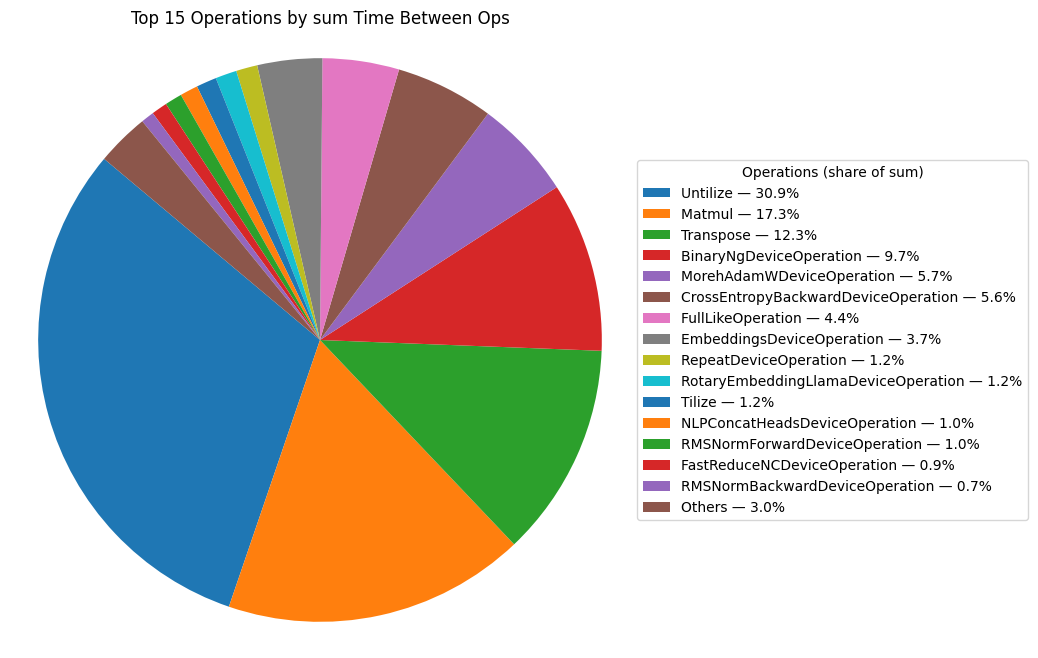

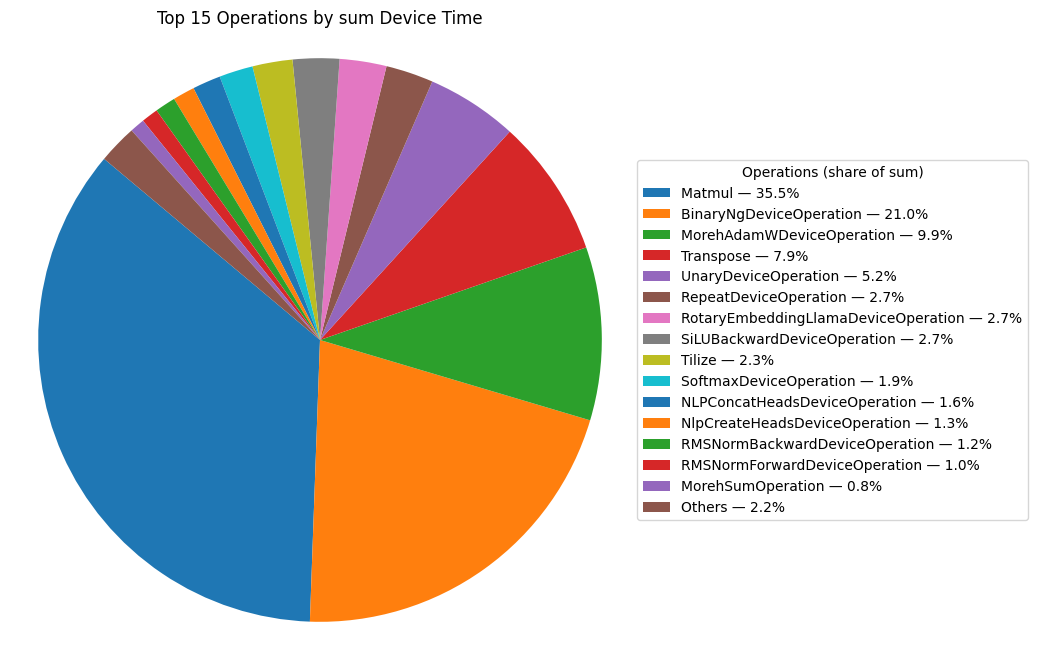

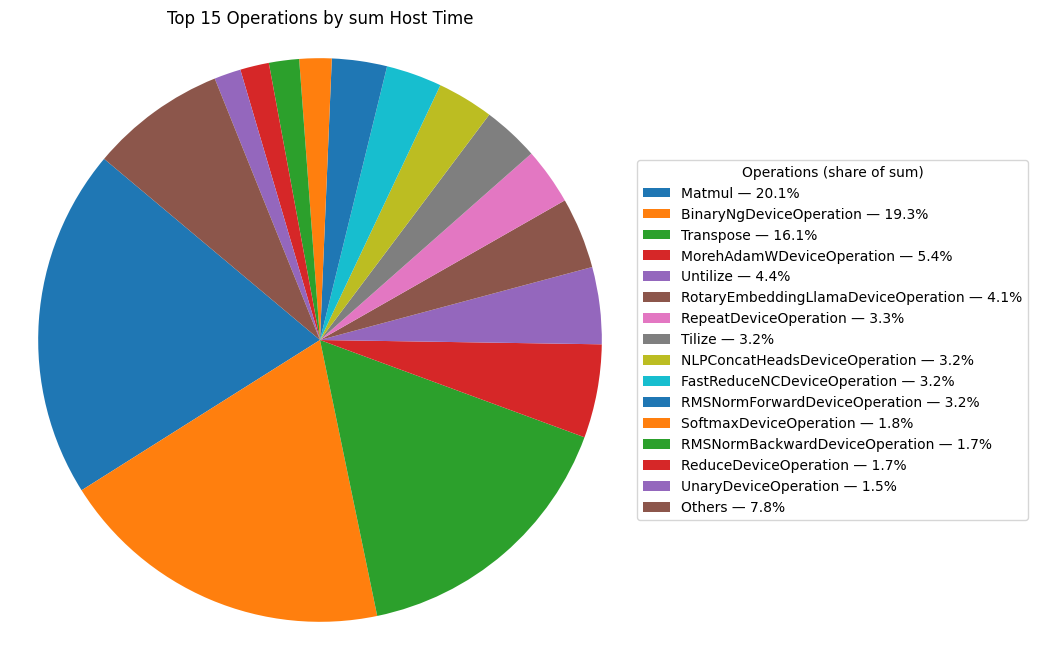

In [37]:
draw_diagrams_with_aggregation('sum')

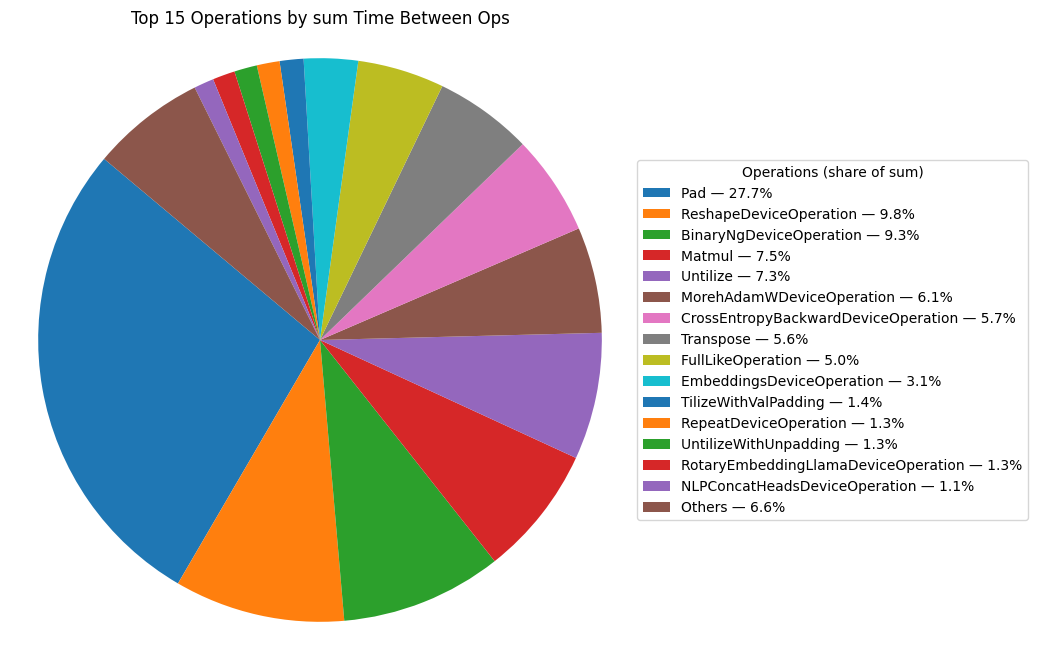

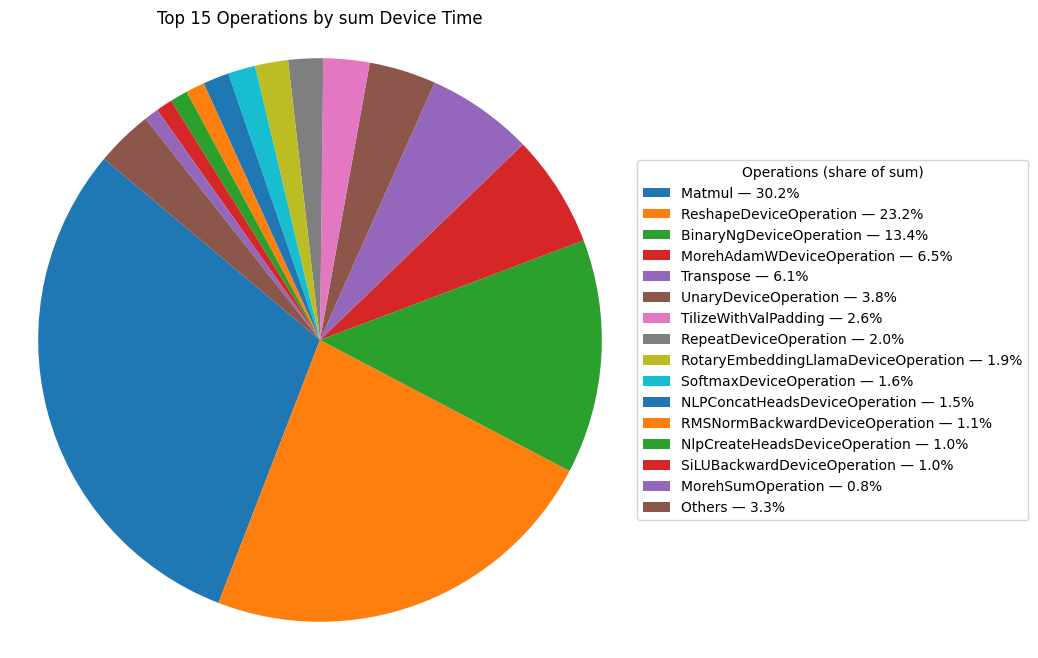

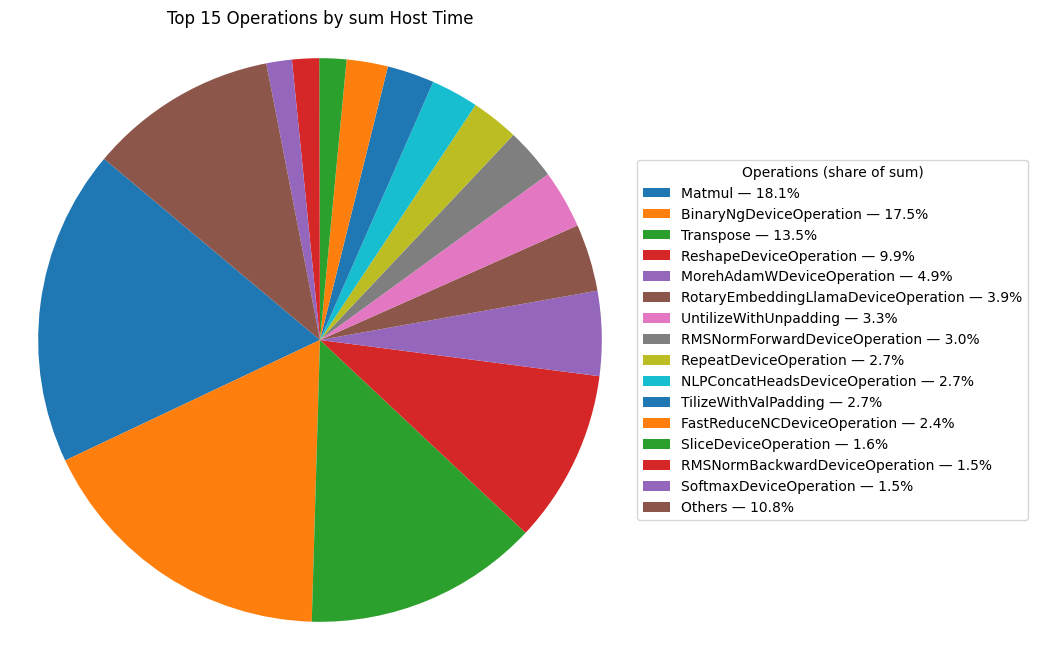

In [35]:
draw_diagrams_with_aggregation('sum')

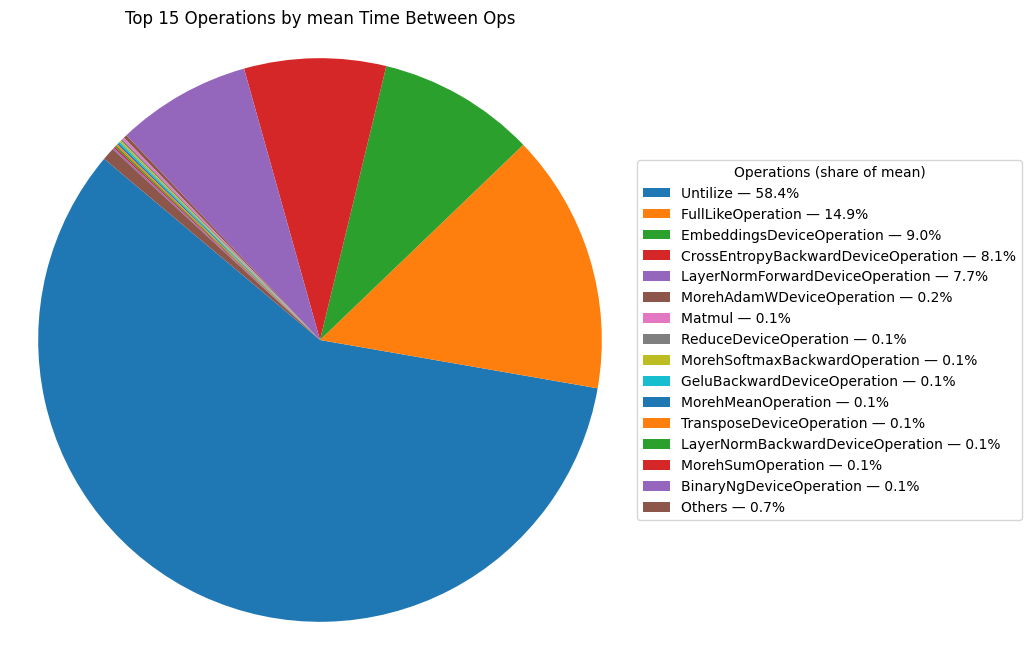

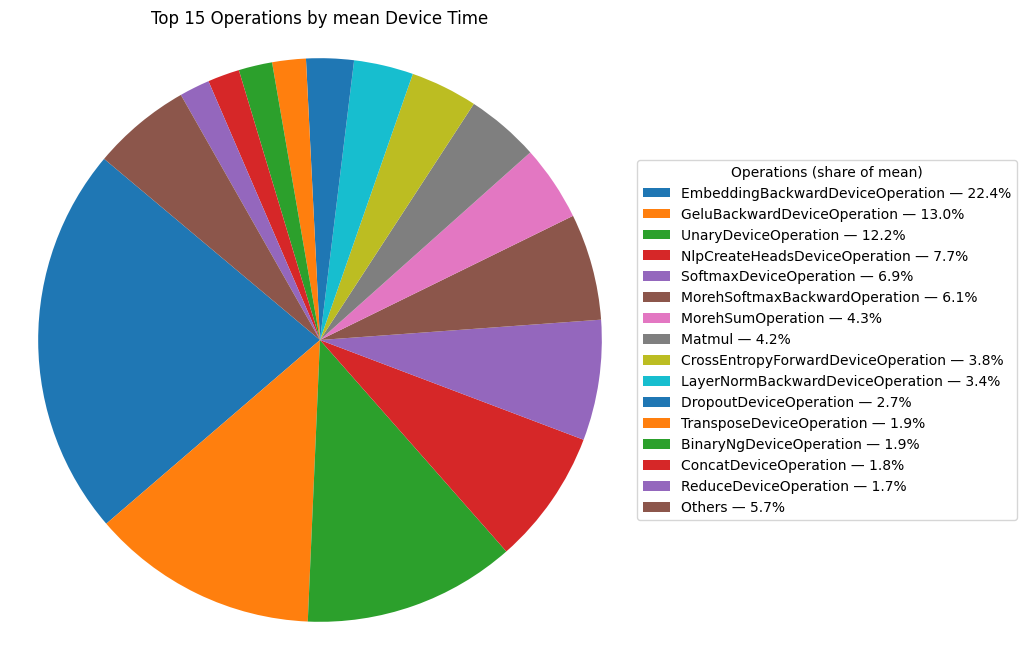

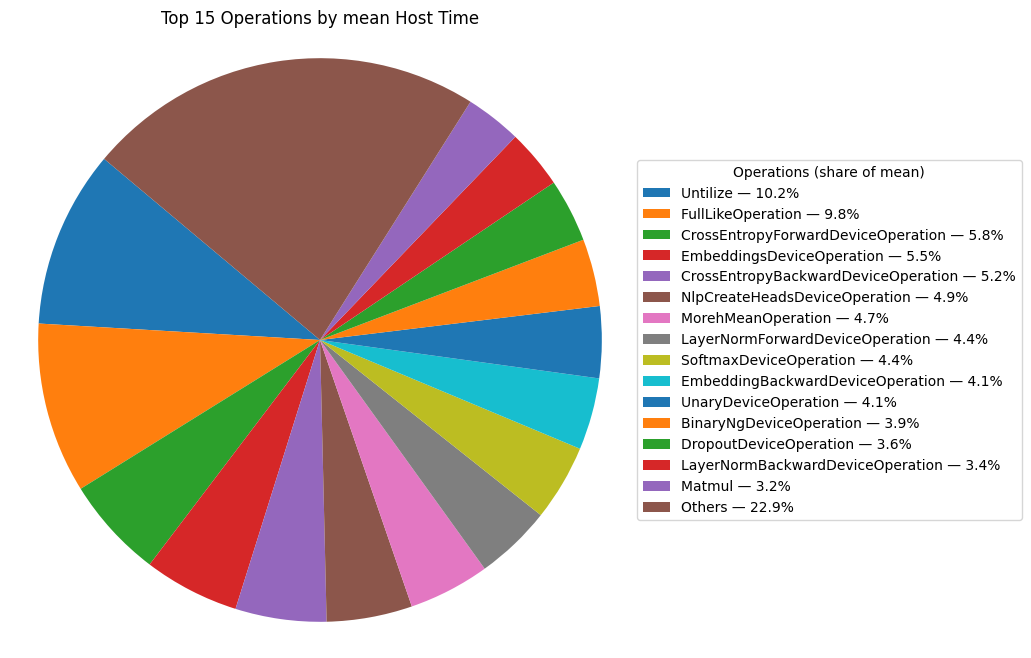

In [6]:
draw_diagrams_with_aggregation('mean')

In [11]:
def name_per_aggregation(aggregation):
    if aggregation == 'sum':
        return 'Total (per training step)'
    elif aggregation == 'mean':
        return 'Average'
    else:
        raise ValueError(f"Unsupported aggregation: {aggregation}")
    
def draw_charts_with_aggregation(aggregation):
    grouped = df.groupby('Operation').agg({
        'Host Time': aggregation,
        'Time Between Ops': aggregation,
        'Device Time': aggregation
    })

    time_columns = ['Time Between Ops', 'Device Time', 'Host Time']

    # Loop through each time column to create horizontal bar charts and pie charts
    for col in time_columns:
        # Extract the total times per operation for the current column
        total_times = grouped[col] / 1_000_000  # Convert from nanoseconds to milliseconds
        if aggregation == 'sum':
            total_times /= num_training_steps  # Normalize by number of training steps if aggregation is 'sum'
        
        # Create a horizontal bar chart
        plt.figure(figsize=(10, 6))
        total_times.sort_values().plot(kind='barh', color='skyblue') 
        plt.title(f'{name_per_aggregation(aggregation)} {col} per Operation')
        plt.xlabel(f'{name_per_aggregation(aggregation)} {col} (ms)')
        plt.ylabel('Operation')
        plt.tight_layout()
        plt.show()

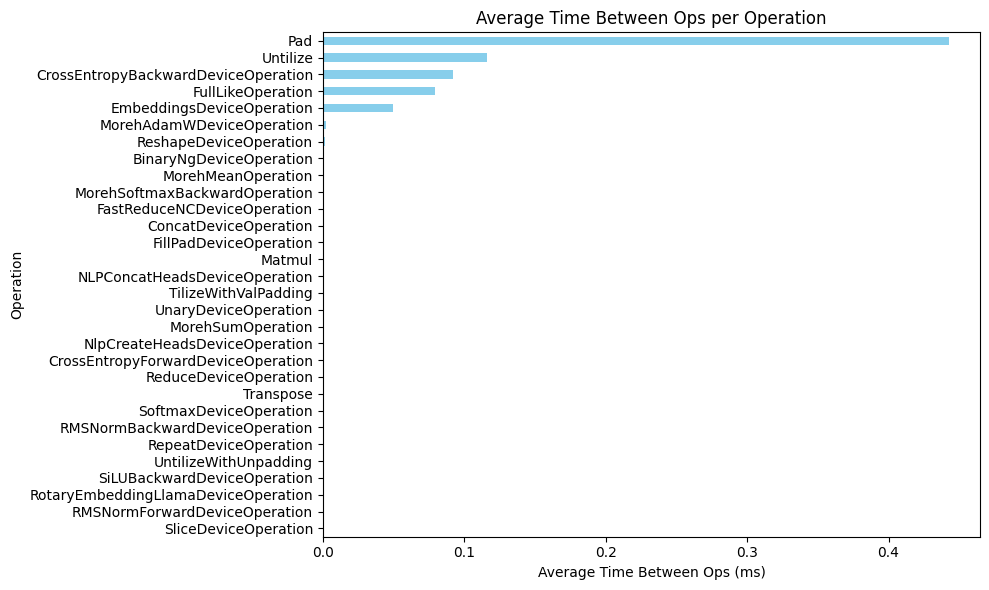

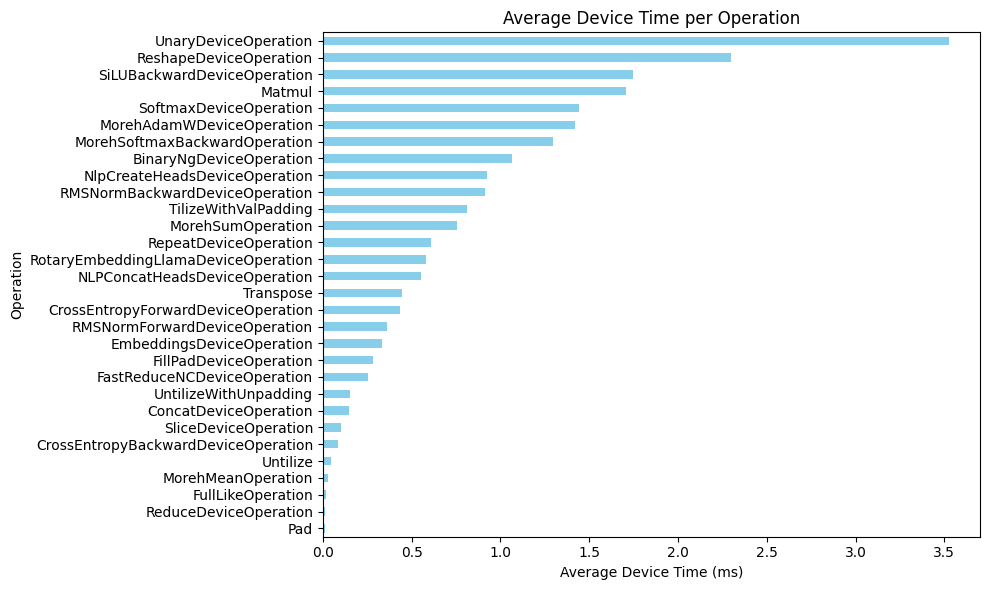

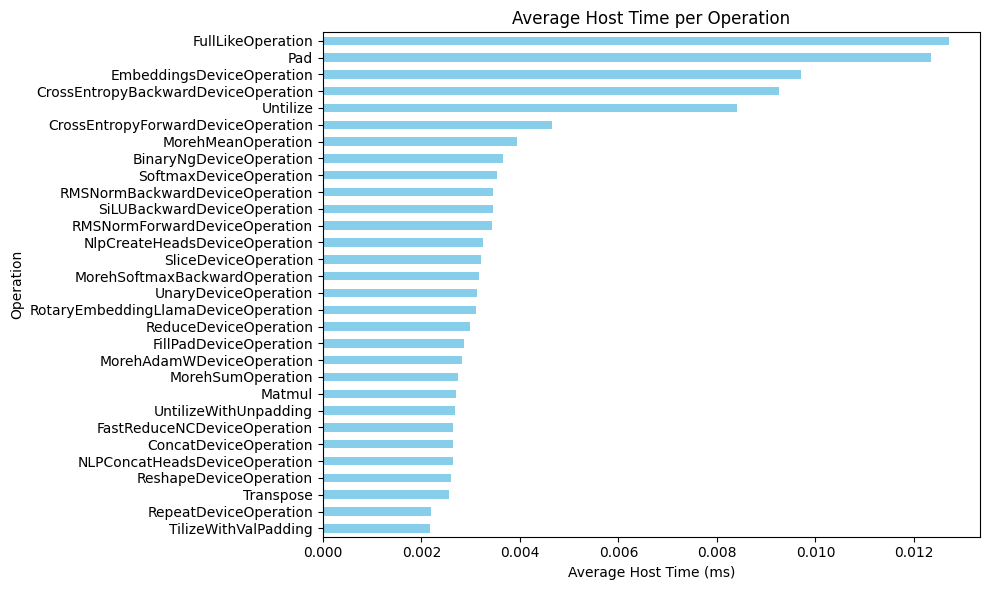

In [12]:
draw_charts_with_aggregation('mean')

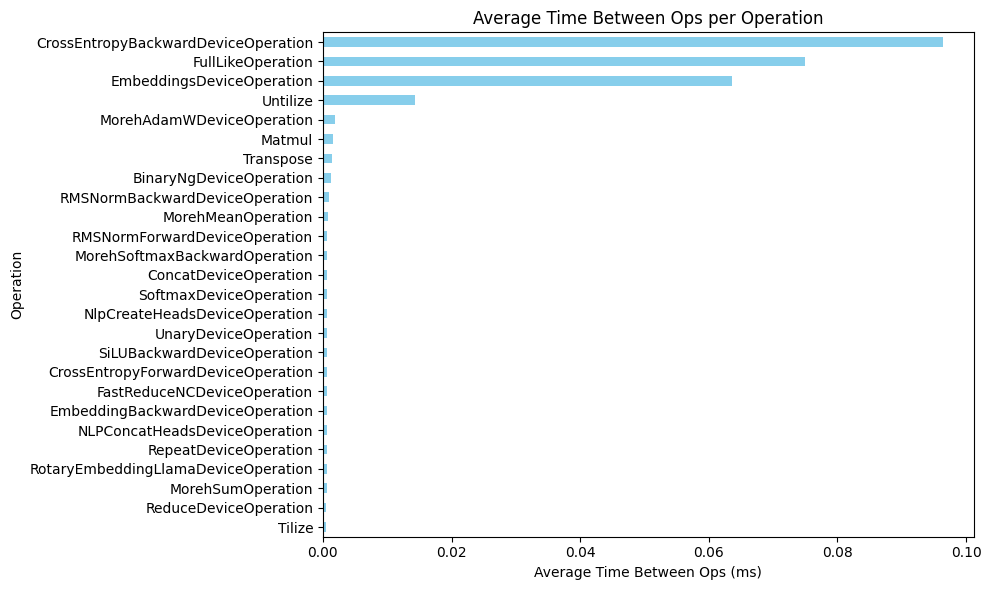

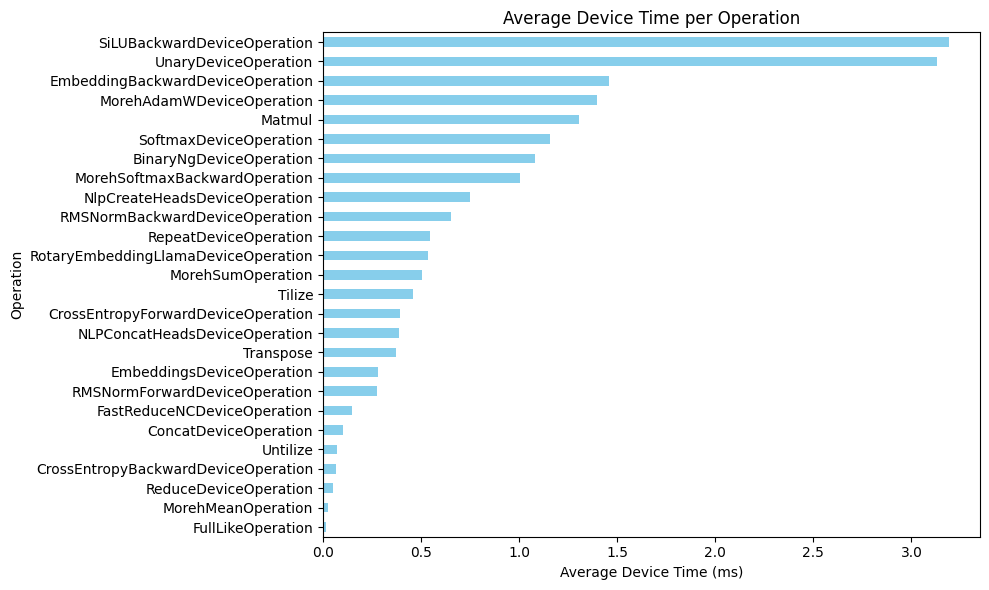

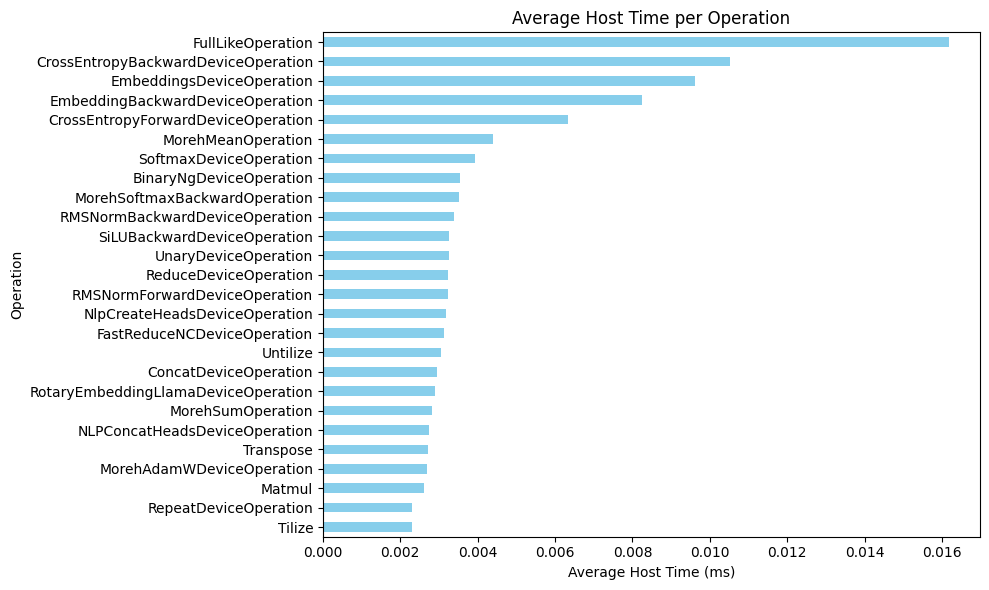

In [14]:
draw_charts_with_aggregation('mean')

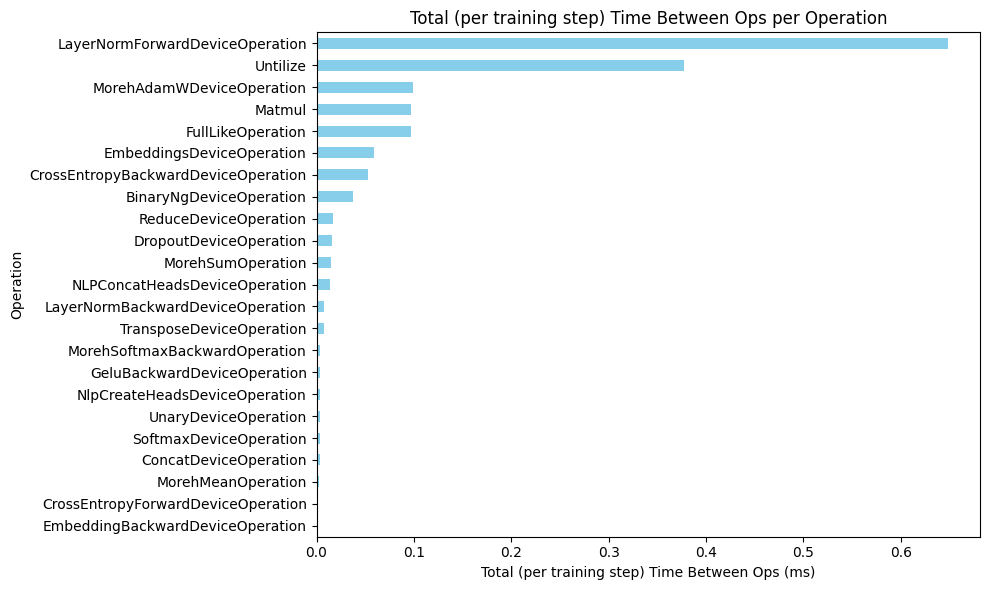

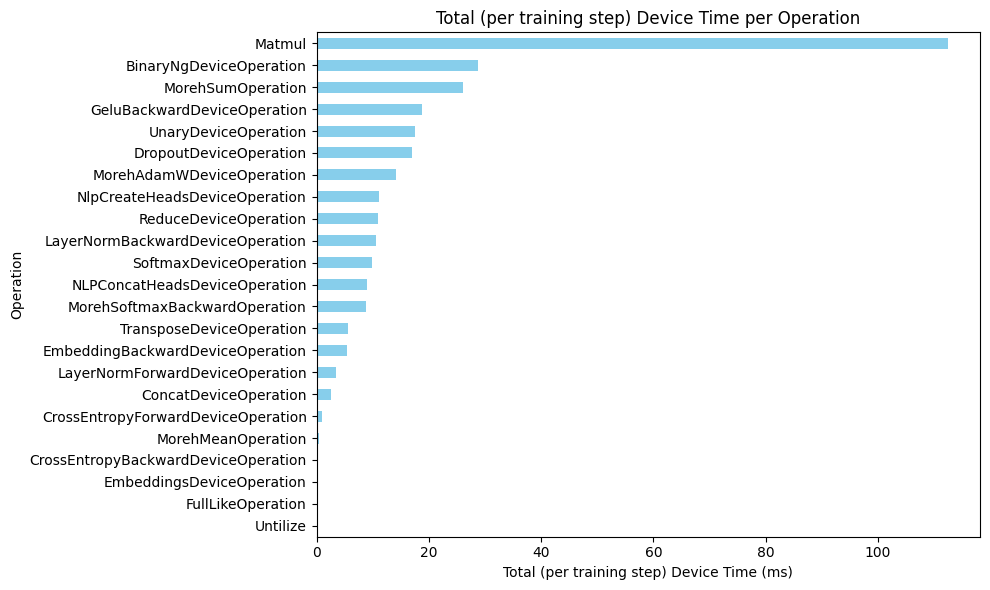

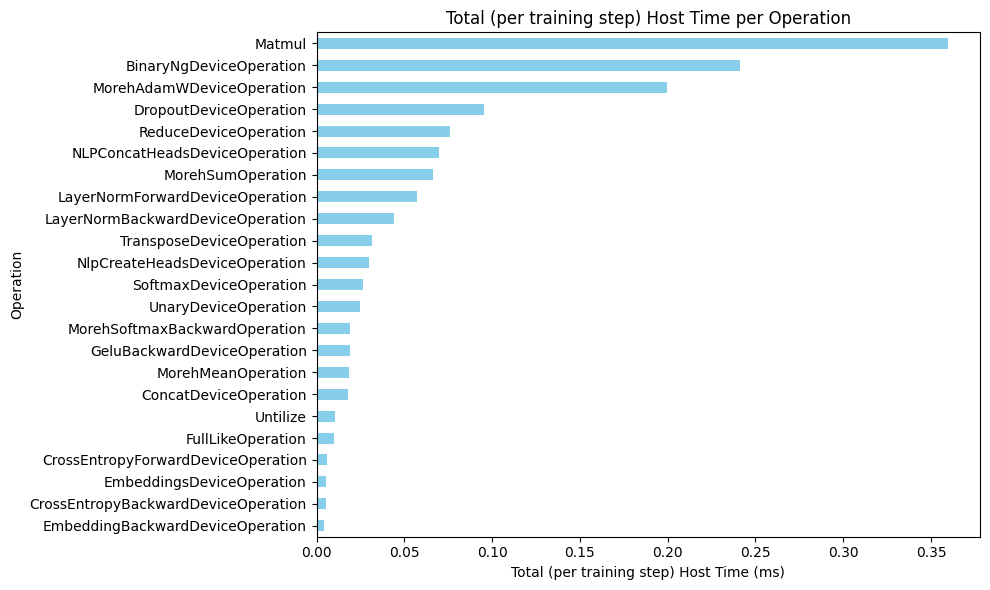

In [9]:
draw_charts_with_aggregation('sum')

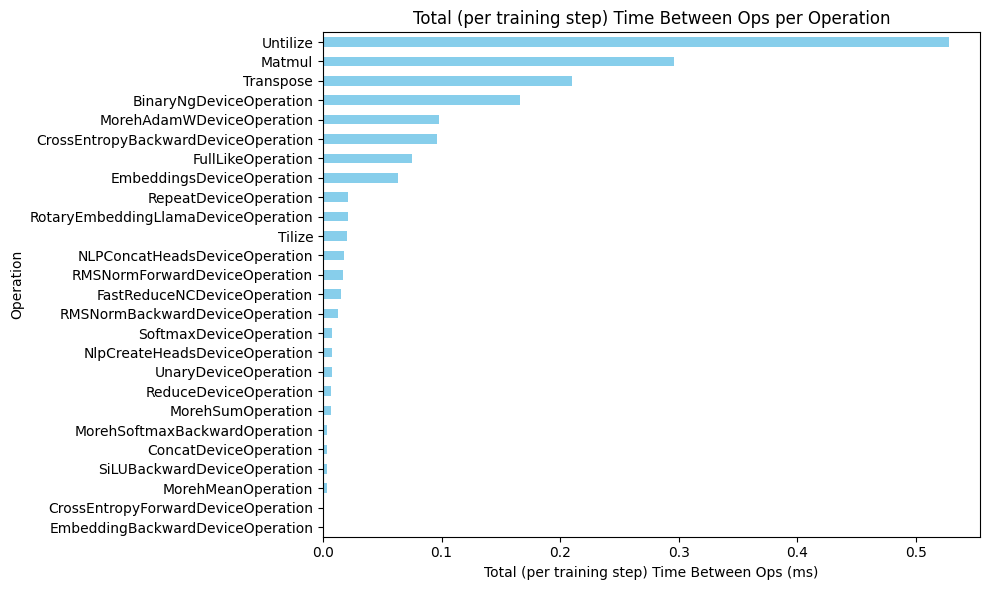

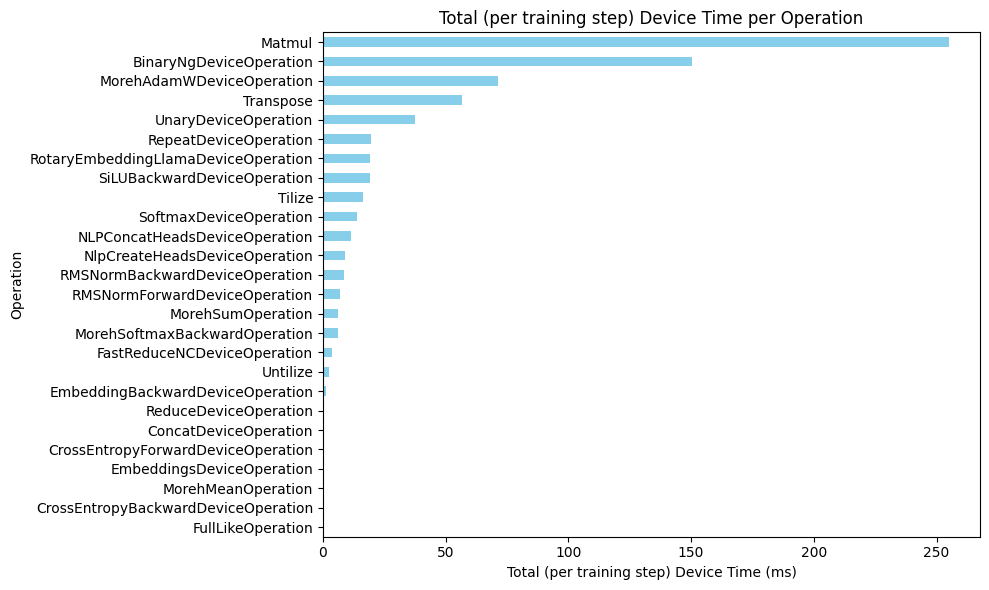

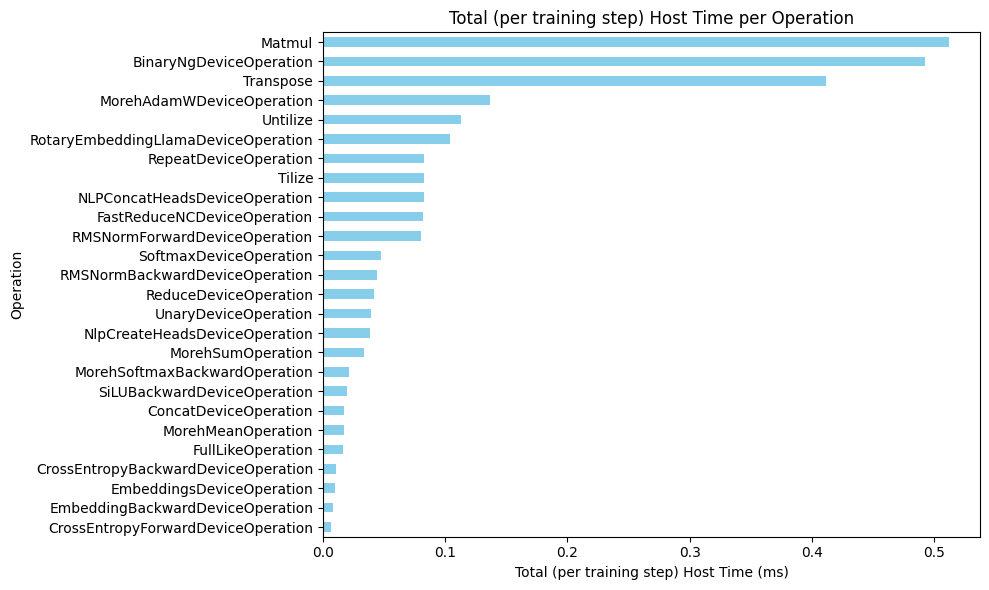

In [15]:
draw_charts_with_aggregation('sum')

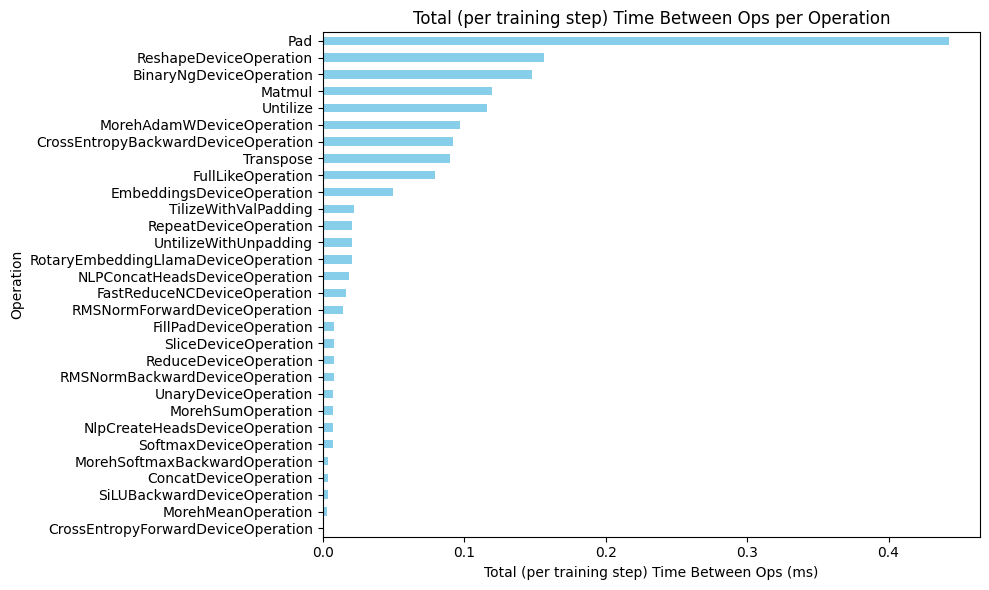

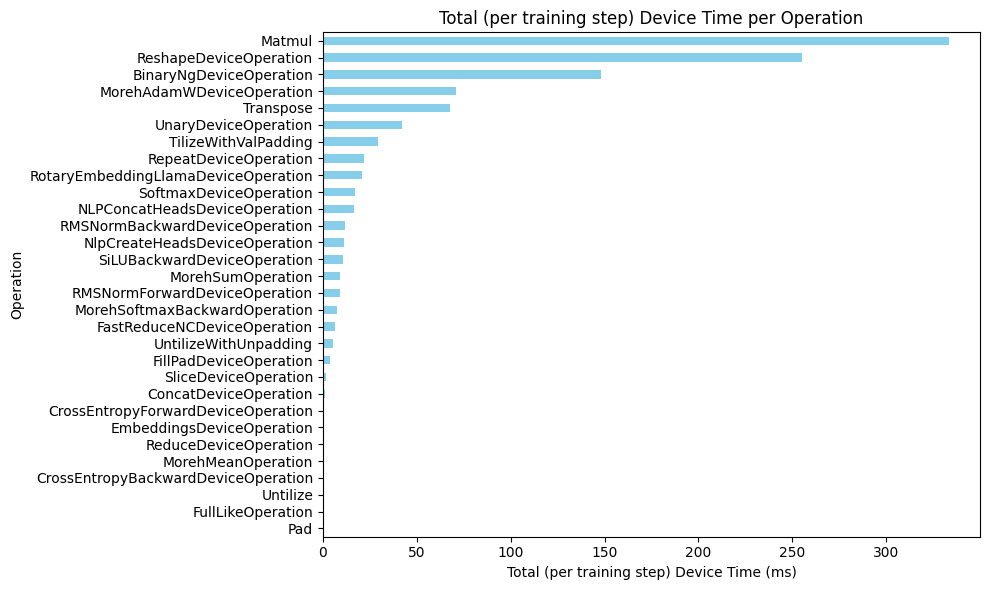

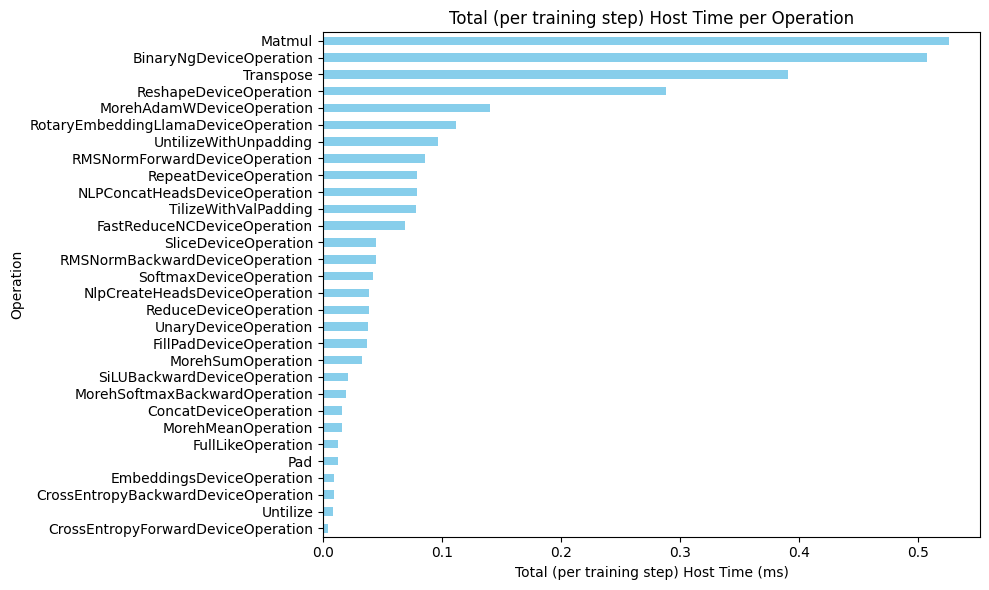

In [17]:
draw_charts_with_aggregation('sum')

In [10]:
@interact(operation=all_operations)
def draw_per_operation_stats(operation):
    df_op = df[df['Operation'] == operation]
    if df_op.empty:
        print(f"No data available for operation: {operation}")
        return

    metrics = [
        ('Host Time (ms)',          df_op['Host Time']        / 1_000_000),
        ('Time Between Ops (ms)',   df_op['Time Between Ops'] / 1_000_000),
        ('Device Time (ms)',        df_op['Device Time']      / 1_000_000),
    ]

    for title, series in metrics:
        # --- build figure explicitly so we know which one to close ------------
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(series.index, series.values, marker='o', color='red')
        ax.set_title(f'{operation} – {title}')
        ax.set_xlabel('Index')
        ax.set_ylabel(title)
        ax.grid(True)
        fig.tight_layout()
        plt.show()

interactive(children=(Dropdown(description='operation', options=('Untilize', 'EmbeddingsDeviceOperation', 'Bin…

In [ ]:
# example how to manually extract performance data for a specific operation
e = df[df['Operation'] == 'Untilize']
e = e[['Operation', 'Host Time', 'Time Between Ops', 'Device Time']]
e

In [ ]:
metrics = ['Host Time', 'Time Between Ops', 'Device Time']

def anomaly_detection_per_operation(operation, metric):
    df_op = df[df['Operation'] == operation]
    if df_op.empty:
        print(f"No data available for operation: {operation}")
        return

    # Calculate the mean and standard deviation for each metric
    
    series = df_op[metric]
    
    mean = series.mean()
    std_dev = series.std()
    
    # Identify anomalies as points that are more than 3 standard deviations from the mean
    anomalies = series[(series < mean - 3 * std_dev) | (series > mean + 3 * std_dev)]
    
    if not anomalies.empty:
        return df_op.loc[anomalies.index]
    return None

In [8]:
import datasets

# Load GSM8K dataset
dataset = datasets.load_dataset('openai/gsm8k', 'main', split=['train', 'test'])

# Convert dataset to pandas DataFrame and save as CSV
import pandas as pd

def save_gsm8k_to_csv(dataset, output_dir='/home/ubuntu/tt-metal/data/'):
    """Save GSM8K dataset splits to CSV files."""
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    for split_name, split_data in zip(['train', 'test'], dataset):
        # Convert to pandas DataFrame
        df = pd.DataFrame(split_data)
        
        # Save to CSV
        csv_path = os.path.join(output_dir, f'gsm8k_{split_name}.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved {split_name} split ({len(df)} examples) to {csv_path}")
    
    return dataset

# Save the dataset
gsm8k_dataset = save_gsm8k_to_csv(dataset)

# Display first few examples
print("\nFirst example from train split:")
print(gsm8k_dataset['train'][0])

Saved train split (7473 examples) to /home/ubuntu/tt-metal/data/gsm8k_train.csv
Saved test split (1319 examples) to /home/ubuntu/tt-metal/data/gsm8k_test.csv

First example from train split:


TypeError: list indices must be integers or slices, not str

In [ ]:
import json

def is_not_nan(value):
    """Check if a value is not NaN."""
    return pd.notna(value) and value != 'NaN' and value != 'nan' and value != ''

@interact(operation=all_operations, metric_name=metrics)
def show_anomalies_attributes_per_metric(operation, metric_name):
    anomaly_df = anomaly_detection_per_operation(operation, metric_name)

    if anomaly_df is None:
        print(f"No anomalies detected for {operation} in {metric_name}.")
        return

    for index, row in anomaly_df.iterrows():
        attr = row['ATTRIBUTES']
        core_count = row['CORE COUNT']
        metric_value = row[metric_name]

        # find all columns with prefix `INPUT_`
        input_columns = [col for col in row.index if col.startswith('INPUT_')]
        input_values = {col: row[col] for col in input_columns if is_not_nan(row[col])}

        # improve print of dictionary with json
        input_values = json.dumps(input_values, indent=8)

        if isinstance(attr, str):
            attr = attr.replace(';', ',')
            attr = attr.replace('\'', '"')
            try:
                attr = json.loads(attr)
            except:
                pass
            attr = json.dumps(attr, indent=8) if isinstance(attr, dict) else attr

        print(f"Anomaly at index {index}: ")
        print(f"    {metric_name} = {metric_value / 1_000_000} ms")
        print(f"    core count = {core_count}")
        print(f"    inputs = {input_values}")
        print(f"    attributes = {attr}")
